In [16]:
%matplotlib inline
import glob
import matplotlib.pyplot as plt
import cv2
import numpy as np

In [9]:
images = [plt.imread(image_path) for image_path in glob.glob('test_images/test*.jpg')]

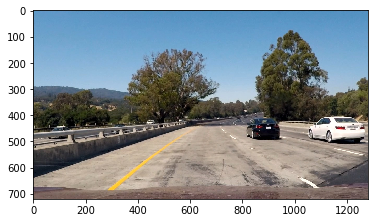

In [10]:
plt.imshow(images[0])

In [24]:
def plot_images(images):
    image_count = len(images)
    fig = plt.figure(figsize=(24, 12))
    for i, image in enumerate(images):
        tmp = fig.add_subplot(1, image_count, i+1)
        tmp.imshow(image)
    plt.show()

In [14]:
def get_satruated_pixels(image):
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
    S = hls[:, :, 2]
    thresh = (90, 255)
    binary = np.zeros_like(S)
    binary[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary


In [53]:
def get_hsv(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    H = hsv[:, :, 0]
    thresh = (10,100)
    binary = np.zeros_like(H)
    binary[(H > thresh[0]) & (H <= thresh[1])] = 1
    return binary

In [63]:
def get_white_line(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    V = hsv[:, :, 2]
    thresh = (220,255)
    binary = np.zeros_like(V)
    binary[(V > thresh[0]) & (V <= thresh[1])] = 1
    return binary

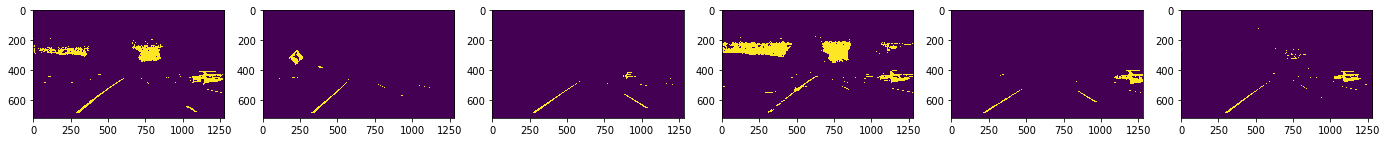

In [66]:
plot_images([get_white_line(img) for img in images])

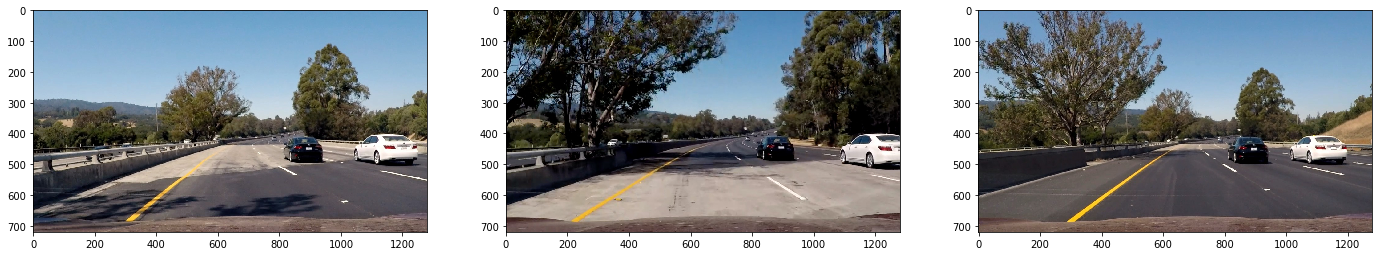

In [43]:
plot_images([img for img in images[3:]])